## UKBB+HCP GLM

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from imports import *

/ext3/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2025-02-04 15:55:19.263255: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-04 15:55:20.985371: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-04 15:55:22.927116: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from models import *
from data import * 
from env import *
from harmonize import *
from sim import *

In [4]:
# overall imports
import importlib
import data

# sim imports
import sim.sim 
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
from sim.sim import Simulation
from sim.sim_run import single_sim_run, open_pickled_results

# data load
from data.data_load import load_transcriptome, load_connectome, load_coords
from data.data_viz import plot_connectome, plot_connectome_with_labels, plot_transcriptome
importlib.reload(data.data_load)
importlib.reload(data.data_viz)

# data utils
from data.data_utils import (
    reconstruct_connectome,
    reconstruct_upper_triangle,
    make_symmetric,
    expand_X_symmetric,
    expand_Y_symmetric,
    expand_X_symmetric_shared,
    expand_shared_matrices,
    process_cv_splits,  
    expanded_inner_folds_combined_plus_indices
)

import data.data_utils
importlib.reload(data.data_utils)

# cross-validation classes
import data.cv_split
from data.cv_split import RandomCVSplit, SchaeferCVSplit, CommunityCVSplit, SubnetworkCVSplit
importlib.reload(data.cv_split)

# sim class
import sim.sim 
from sim.sim import Simulation
importlib.reload(sim.sim)


<module 'sim.sim' from '/scratch/asr655/neuroinformatics/GeneEx2Conn/sim/sim.py'>

In [5]:
print_system_usage()

total = psutil.disk_usage('/').total
print(bytes2human(total))

CPU Usage: 16.2%
RAM Usage: 7.4%
Available RAM: 349.1G
Total RAM: 376.8G
52.4G


In [6]:
GPUtil.getAvailable()

[]

#### Create desired subsetted dataset

Full brain

In [7]:
HCP_enigma_structural_count, HCP_enigma_labels, HCP_enigma_lh_indices, HCP_enigma_rh_indices = load_connectome(measure='SC', omit_subcortical=False, include_labels=True)
HCP_enigma_functional_conn = load_connectome(measure='FC', omit_subcortical=False)
HCP_coords = load_coords(parcellation='S100', omit_subcortical=False)
AHBA_transcriptome = load_transcriptome(parcellation='S100', omit_subcortical=False)

Full cortex

In [8]:
HCP_enigma_structural_count_cortical, HCP_enigma_labels_cortical, HCP_enigma_lh_indices_cortical, HCP_enigma_rh_indices_cortical = load_connectome(measure='SC', omit_subcortical=True, include_labels=True)
HCP_enigma_functional_conn_cortical = load_connectome(measure='FC', omit_subcortical=True)
HCP_coords_cortical = load_coords(parcellation='S100', omit_subcortical=True)
AHBA_transcriptome_cortical = load_transcriptome(parcellation='S100', omit_subcortical=True)

Cortical left

In [9]:
HCP_enigma_structural_count_left, HCP_enigma_labels_left, HCP_enigma_lh_indices_left, HCP_enigma_rh_indices_left = load_connectome(measure='SC', omit_subcortical=True, hemisphere='left', include_labels=True)
HCP_enigma_functional_conn_left = load_connectome(measure='FC', omit_subcortical=True, hemisphere='left')
HCP_coords_left = load_coords(parcellation='S100', omit_subcortical=True, hemisphere='left')
AHBA_transcriptome_left = load_transcriptome(parcellation='S100', omit_subcortical=True, hemisphere='left')

Cortical right

In [10]:
HCP_enigma_structural_count_right, HCP_enigma_labels_right, HCP_enigma_lh_indices_right, HCP_enigma_rh_indices_right = load_connectome(measure='SC', omit_subcortical=True, hemisphere='right', include_labels=True)
HCP_enigma_functional_conn_right = load_connectome(measure='FC', omit_subcortical=True, hemisphere='right')
HCP_coords_right = load_coords(parcellation='S100', omit_subcortical=True, hemisphere='right')
AHBA_transcriptome_right = load_transcriptome(parcellation='S100', omit_subcortical=True, hemisphere='right')

Interconnections

In [11]:
# For connectivity matrices, need to mask both rows and columns
HCP_structural_count_interconnections = HCP_enigma_structural_count_cortical[HCP_enigma_lh_indices_cortical][:, HCP_enigma_rh_indices_cortical]
HCP_functional_conn_interconnections = HCP_enigma_functional_conn_cortical[HCP_enigma_lh_indices_cortical][:, HCP_enigma_rh_indices_cortical]
print("Interconnections structural connectivity shape:", HCP_structural_count_interconnections.shape)
print("Interconnections functional connectivity shape:", HCP_functional_conn_interconnections.shape)

Interconnections structural connectivity shape: (50, 50)
Interconnections functional connectivity shape: (50, 50)


### Modeling tests

#### Construct the features for the GLM 

All edges

In [12]:
# Define dataset
X = AHBA_transcriptome
Y_sc = HCP_enigma_structural_count
Y_fc = HCP_enigma_functional_conn
mni_coords = HCP_coords
mask = np.array([True] * len(HCP_enigma_labels))

# X = AHBA_transcriptome_cortical
# Y_sc = HCP_enigma_structural_count_cortical
# Y_fc = HCP_enigma_functional_conn_cortical
# mni_coords = HCP_coords_cortical
# mask = np.array([True] * len(HCP_enigma_labels_cortical))

Text(0.5, 0, 'Genes')

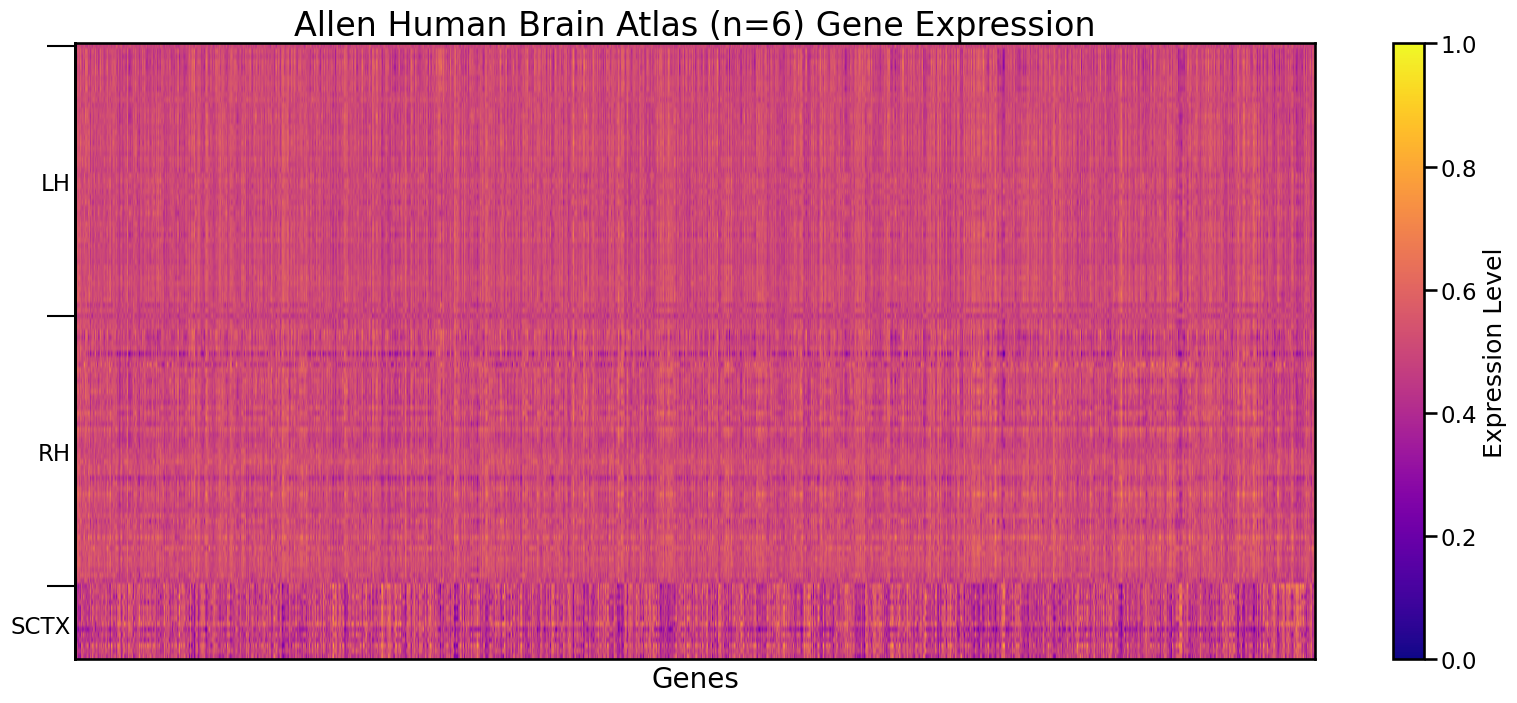

In [13]:
# Visualize transcriptome matrix
plt.figure(figsize=(20, 8))
plt.imshow(X, aspect='auto', cmap='plasma', vmin = 0, vmax = 1)
plt.colorbar(label='Expression Level')
plt.title('Allen Human Brain Atlas (n=6) Gene Expression', fontsize=24)

# Remove default ticks
plt.gca().set_xticks([])
plt.gca().set_yticks([])

# Add region labels on y-axis
sec_ay = plt.gca().secondary_yaxis(location=0)
sec_ay.set_yticks([25, 75, 107], labels=['LH', 'RH', 'SCTX'])
sec_ay.tick_params('y', length=0)

# Add lines between regions on y-axis
sec_ay_lines = plt.gca().secondary_yaxis(location=0)
sec_ay_lines.set_yticks([0, 50, 100, 114], labels=[])
sec_ay_lines.tick_params('y', length=20, width=1.5)

# Add x-axis label
plt.xlabel('Genes', fontsize=20)


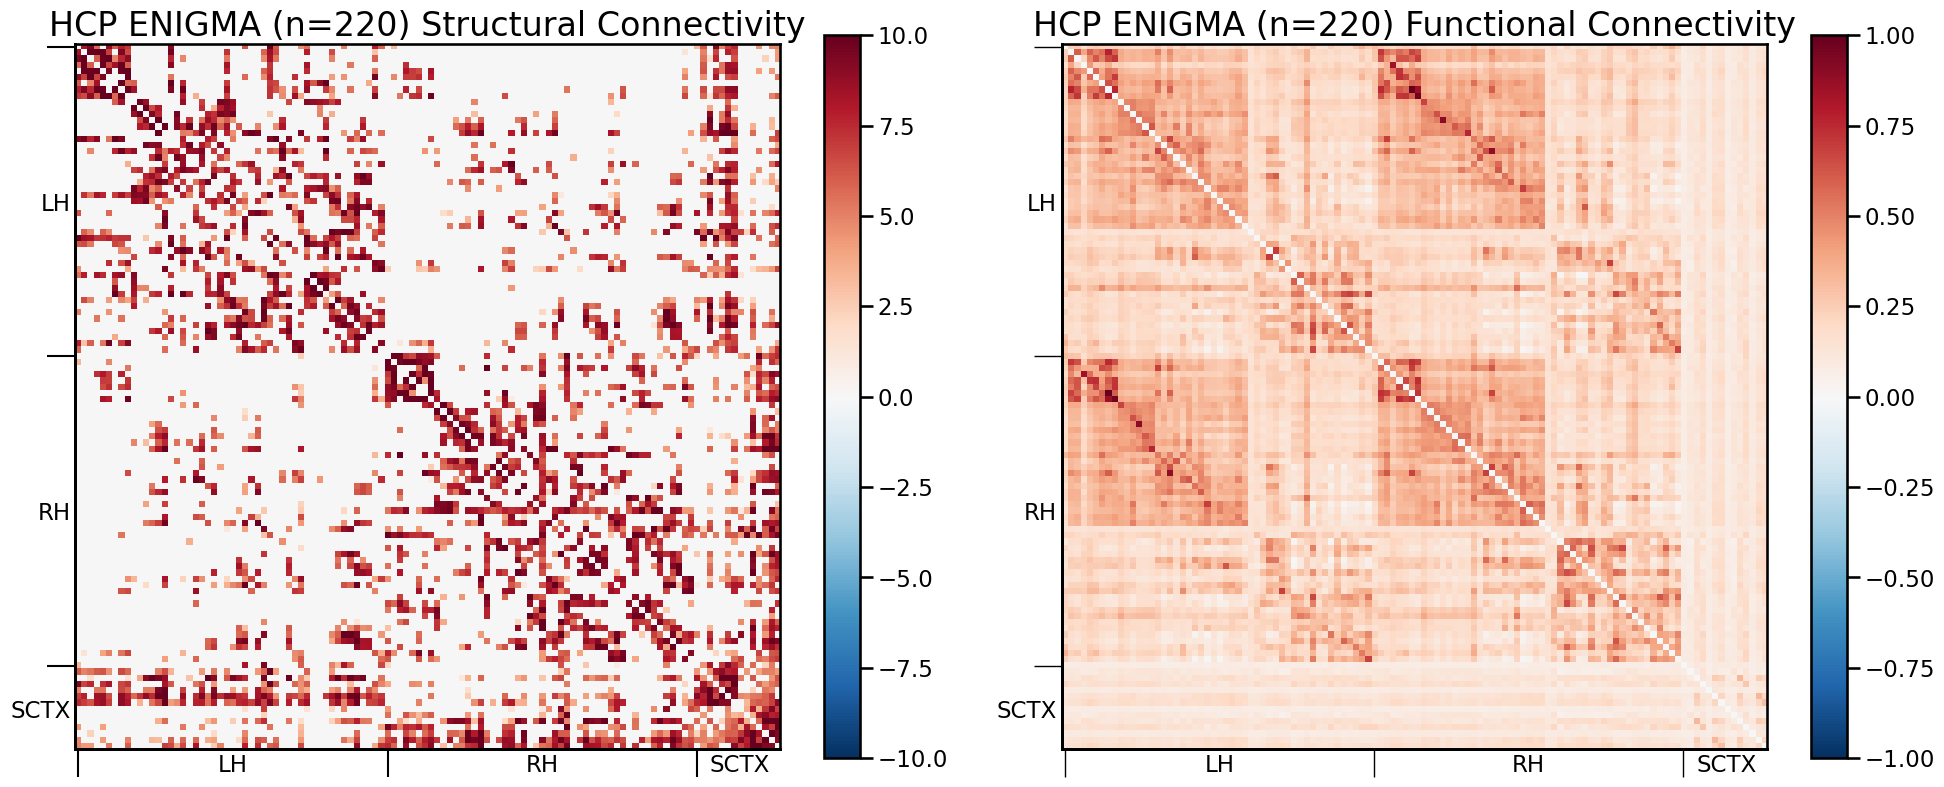

In [14]:
# Visualize structural and functional connectivity matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot structural connectivity
im1 = ax1.imshow(Y_sc, cmap='RdBu_r', vmin=-10, vmax=10)
ax1.set_title('HCP ENIGMA (n=220) Structural Connectivity', fontsize=24)
plt.colorbar(im1, ax=ax1)

# Remove main ticks
ax1.set_xticks([])
ax1.set_yticks([])
# Secondary axis for region labels - structural
sec_ax1 = ax1.secondary_xaxis(location=0)
sec_ax1.set_xticks([25, 75, 107], labels=['LH', 'RH', 'SCTX'])
sec_ax1.tick_params('x', length=0)

# Add lines between regions - structural x-axis
sec_ax1_lines = ax1.secondary_xaxis(location=0)
sec_ax1_lines.set_xticks([0, 50, 100, 114], labels=[])
sec_ax1_lines.tick_params('x', length=20, width=1.5)

# Secondary axis for region labels - structural y-axis
sec_ay1 = ax1.secondary_yaxis(location=0)
sec_ay1.set_yticks([25, 75, 107], labels=['LH', 'RH', 'SCTX'])
sec_ay1.tick_params('y', length=0)

# Add lines between regions - structural y-axis
sec_ay1_lines = ax1.secondary_yaxis(location=0)
sec_ay1_lines.set_yticks([0, 50, 100, 114], labels=[])
sec_ay1_lines.tick_params('y', length=20, width=1.5)

# Plot functional connectivity
im2 = ax2.imshow(Y_fc, cmap='RdBu_r', vmin=-1, vmax=1)
ax2.set_title('HCP ENIGMA (n=220) Functional Connectivity', fontsize=24)
plt.colorbar(im2, ax=ax2)

# Remove main ticks
ax2.set_xticks([])
ax2.set_yticks([])

# Secondary axis for region labels - functional x-axis
sec_ax2 = ax2.secondary_xaxis(location=0)
sec_ax2.set_xticks([25, 75, 107], labels=['LH', 'RH', 'SCTX'])
sec_ax2.tick_params('x', length=0)

# Add lines between regions - functional x-axis
sec_ax2_lines = ax2.secondary_xaxis(location=0)
sec_ax2_lines.set_xticks([0, 50, 100, 114], labels=[])
sec_ax2_lines.tick_params('x', length=20, width=1)

# Secondary axis for region labels - functional y-axis
sec_ay2 = ax2.secondary_yaxis(location=0)
sec_ay2.set_yticks([25, 75, 107], labels=['LH', 'RH', 'SCTX'])
sec_ay2.tick_params('y', length=0)

# Add lines between regions - functional y-axis
sec_ay2_lines = ax2.secondary_yaxis(location=0)
sec_ay2_lines.set_yticks([0, 50, 100, 114], labels=[])
sec_ay2_lines.tick_params('y', length=20, width=1)

plt.tight_layout()
plt.show()


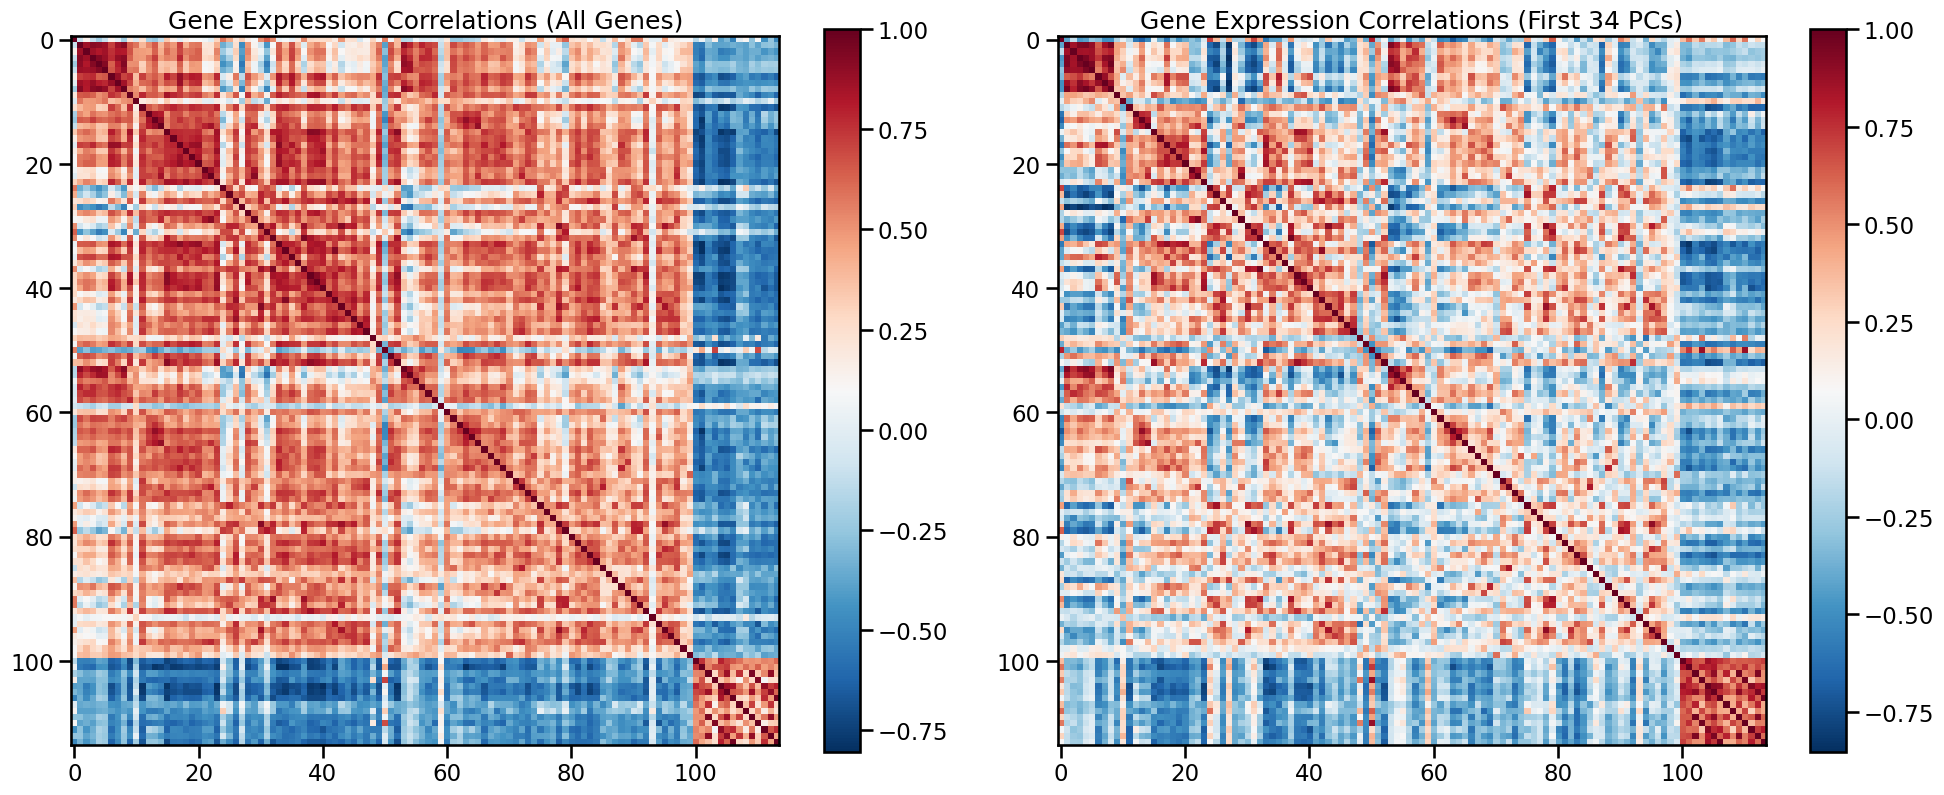

In [15]:
# Calculate gene expression correlations between regions
gene_corr = np.corrcoef(X)

# Calculate PCA of gene expression
pca = PCA()
X_pca = pca.fit_transform(X)

# Find number of components for 95% variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance >= 0.95) + 1
X_pca_95 = X_pca[:, :n_components]

# Calculate correlations using PCA-reduced gene expression
gene_corr_pca = np.corrcoef(X_pca_95)

# Visualize gene expression correlations with PCA
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

im1 = ax1.imshow(gene_corr, cmap='RdBu_r')
ax1.set_title('Gene Expression Correlations (All Genes)')
plt.colorbar(im1, ax=ax1)

im2 = ax2.imshow(gene_corr_pca, cmap='RdBu_r')
ax2.set_title(f'Gene Expression Correlations (First {n_components} PCs)')
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()


Quick test to evaluate necessary number of components for spectral embedding

  return np.asarray(x, float)

  offsets = np.asanyarray(offsets, float)



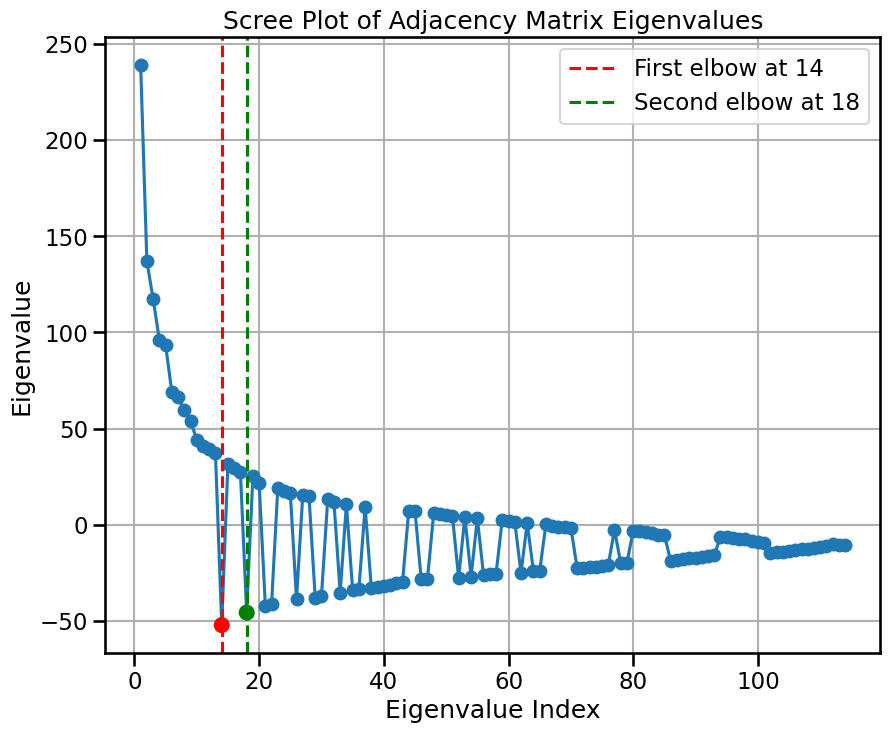

In [16]:
# Compute spectral embeddings using method 'A' on unmasked structural connectivity
adj_eigenvalues, adj_eigenvectors = eig(Y_sc)  # Use unmasked Y_sc

x_adj = range(1, len(adj_eigenvalues) + 1)
d1_adj = np.diff(adj_eigenvalues)
d2_adj = np.diff(d1_adj)
elbow_points_adj = np.argsort(np.abs(d2_adj))[-2:] + 2
first_elbow_adj = min(elbow_points_adj)
second_elbow_adj = max(elbow_points_adj)

# Plot eigenvalues for adjacency matrix embedding
plt.figure(figsize=(10, 8))
plt.plot(x_adj, adj_eigenvalues, marker='o')
plt.axvline(x=first_elbow_adj, color='r', linestyle='--', label=f'First elbow at {first_elbow_adj}')
plt.axvline(x=second_elbow_adj, color='g', linestyle='--', label=f'Second elbow at {second_elbow_adj}')
plt.scatter([first_elbow_adj, second_elbow_adj], 
           [adj_eigenvalues[first_elbow_adj-1], adj_eigenvalues[second_elbow_adj-1]], 
           color=['red', 'green'], s=100, zorder=5)
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot of Adjacency Matrix Eigenvalues')
plt.legend()
plt.grid(True)
plt.show()

Dataset creation function

In [17]:
def construct_features_masked(X, Y_sc, Y_fc, mni_coords, mask_from, mask_to, spectrals):
    """
    Construct features for GLM modeling from input data matrices using masks to specify regions.
    
    Args:
        X: Full gene expression data matrix (AHBA_cortical_transcriptome)
        Y_sc: Full structural connectivity matrix
        Y_fc: Full functional connectivity matrix  
        mni_coords: MNI coordinates for all regions
        mask_from: Boolean mask for source regions (e.g. cortical_mask, left_hemi_mask)
        mask_to: Boolean mask for target regions (e.g. cortical_mask, right_hemi_mask)
        
    Returns:
        Dictionary containing feature arrays and embeddings for the masked subset
    """
    # Get masked coordinates and connectivity matrices
    mni_coords_from = mni_coords[mask_from]
    mni_coords_to = mni_coords[mask_to]
    
    # Get masked connectivity matrices
    Y_sc_masked = Y_sc[mask_from][:, mask_to]
    Y_fc_masked = Y_fc[mask_from][:, mask_to]

    # Compute spectral embeddings using method 'A' on unmasked structural connectivity
    _, eigenvectors = eig(Y_sc)  # Use unmasked Y_sc
    spectral_embeddings_from = eigenvectors[mask_from, :spectrals]  # Apply mask_from after computing eigenvectors
    spectral_embeddings_to = eigenvectors[mask_to, :spectrals]  # Apply mask_to after computing eigenvectors

    # Compute PCA from all gene expression data - determine components for 95% variance
    pca = PCA()
    X_pca_full = pca.fit_transform(X)  # Use unmasked X
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(cumulative_variance >= 0.95) + 1
    # Get masked PCA components
    X_pca_masked_from = X_pca_full[mask_from]
    X_pca_masked_to = X_pca_full[mask_to]
    
    # Get masked gene expression
    X_masked_from = X[mask_from]
    X_masked_to = X[mask_to]

    # Calculate features between all pairs of masked regions
    num_from = len(mni_coords_from)
    num_to = len(mni_coords_to)
    
    distances = []
    sc_values = []
    fc_values = [] 
    gene_coexpression = []
    gene_PCA_coexpression = []
    spectral_similarity = []
    edge_PCA_embeddings = []
    edge_spectral_embeddings = []
    edge_mni_coords = []

    for i in range(num_from):
        for j in range(num_to):
            # Skip self-connections if masks overlap
            if mask_from is mask_to and i >= j:
                continue
                
            # Calculate euclidean distance between regions i and j
            dist = np.sqrt(np.sum((mni_coords_from[i] - mni_coords_to[j])**2))
            distances.append(dist)
            
            # Get connectivity values between regions i and j
            sc_values.append(Y_sc_masked[i, j])
            fc_values.append(Y_fc_masked[i, j])
            
            # Calculate gene expression similarity
            gene_coexp = np.corrcoef(X_masked_from[i], X_masked_to[j])[0,1]
            gene_coexpression.append(gene_coexp)
            
            # Calculate PCA-based gene expression similarity
            gene_pca_coexp = np.corrcoef(X_pca_masked_from[i], X_pca_masked_to[j])[0,1]
            gene_PCA_coexpression.append(gene_pca_coexp)
            
            # Calculate spectral embedding similarity
            spec_sim = np.corrcoef(spectral_embeddings_from[i], spectral_embeddings_to[j])[0,1]
            spectral_similarity.append(spec_sim)
            
            # Store embeddings
            edge_PCA_embeddings.append(np.concatenate([X_pca_masked_from[i], X_pca_masked_to[j]]))
            edge_spectral_embeddings.append(np.concatenate([spectral_embeddings_from[i], spectral_embeddings_to[j]]))
            edge_mni_coords.append(np.concatenate([mni_coords_from[i], mni_coords_to[j]]))

    # Convert lists to arrays
    features = {
        'distances': np.array(distances),
        'sc_values': np.array(sc_values),
        'fc_values': np.array(fc_values),
        'gene_coexpression': np.array(gene_coexpression),
        'gene_PCA_coexpression': np.array(gene_PCA_coexpression),
        'spectral_similarity': np.array(spectral_similarity),
        'edge_PCA_embeddings': np.array(edge_PCA_embeddings),
        'edge_spectral_embeddings': np.array(edge_spectral_embeddings),
        'edge_mni_coords': np.array(edge_mni_coords)
    }
    
    return features

def fit_glm(features, feature_names, target_name='fc_values'):
    """
    Fit GLM model with specified features and calculate individual R^2 values
    
    Parameters:
    features (dict): Dictionary containing feature arrays
    feature_names (list): List of feature names to include in model
    target_name (str): Name of target feature to predict (default: 'fc_values')
    """
    # Get target variable
    target = features[target_name]
    
    # Prepare data for GLM
    X_glm = np.column_stack([features[name] for name in feature_names])
    X_glm = sm.add_constant(X_glm)  # Add constant
    
    print("Feature matrix shape:", X_glm.shape)
    
    # Fit full model
    model = sm.OLS(target, X_glm)
    results = model.fit()
    
    # Print full model summary
    print("\nFull model summary:")
    print(results.summary())
    
    # Calculate R^2 for individual features
    print("\nIndividual feature R^2 values:")
    r_squared_values = {}
    for name in feature_names:
        X_single = sm.add_constant(features[name])
        r_squared = sm.OLS(target, X_single).fit().rsquared
        r_squared_values[name] = r_squared
        print(f"R^2 for {name}: {r_squared:.3f}")
        
    return results, r_squared_values

In [18]:
# Call the function with our datasets
features = construct_features_masked(
    X,
    Y_sc,
    Y_fc,
    mni_coords,
    mask_from=mask,
    mask_to=mask, 
    spectrals=13
)
print("Distances shape:", features['distances'].shape)
print("SC values shape:", features['sc_values'].shape)
print("FC values shape:", features['fc_values'].shape)
print("Gene coexpression shape:", features['gene_coexpression'].shape)
print("Gene PCA coexpression shape:", features['gene_PCA_coexpression'].shape)
print("Spectral similarity shape:", features['spectral_similarity'].shape)
print("Gene PCA shape:", features['edge_PCA_embeddings'].shape)
print("Spectral embeddings shape:", features['edge_spectral_embeddings'].shape)
print("MNI coordinates shape:", features['edge_mni_coords'].shape)

# Run GLM with 1D features
feature_names = ['distances', 'sc_values', 'gene_coexpression', 'gene_PCA_coexpression', 'spectral_similarity']
results, r_squared_values = fit_glm(features, feature_names, target_name='fc_values')

# Run GLM with all features
feature_names = ['distances', 'sc_values', 'gene_coexpression', 'gene_PCA_coexpression', 'spectral_similarity', 'edge_PCA_embeddings', 'edge_spectral_embeddings', 'edge_mni_coords']
results, r_squared_values = fit_glm(features, feature_names, target_name='fc_values')

Distances shape: (6441,)
SC values shape: (6441,)
FC values shape: (6441,)
Gene coexpression shape: (6441,)
Gene PCA coexpression shape: (6441,)
Spectral similarity shape: (6441,)
Gene PCA shape: (6441, 228)
Spectral embeddings shape: (6441, 26)
MNI coordinates shape: (6441, 6)
Feature matrix shape: (6441, 6)

Full model summary:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     469.6
Date:                Tue, 04 Feb 2025   Prob (F-statistic):               0.00
Time:                        15:55:59   Log-Likelihood:                 5481.0
No. Observations:                6441   AIC:                        -1.095e+04
Df Residuals:                    6435   BIC:                        -1.091e+04
Df Model:                           

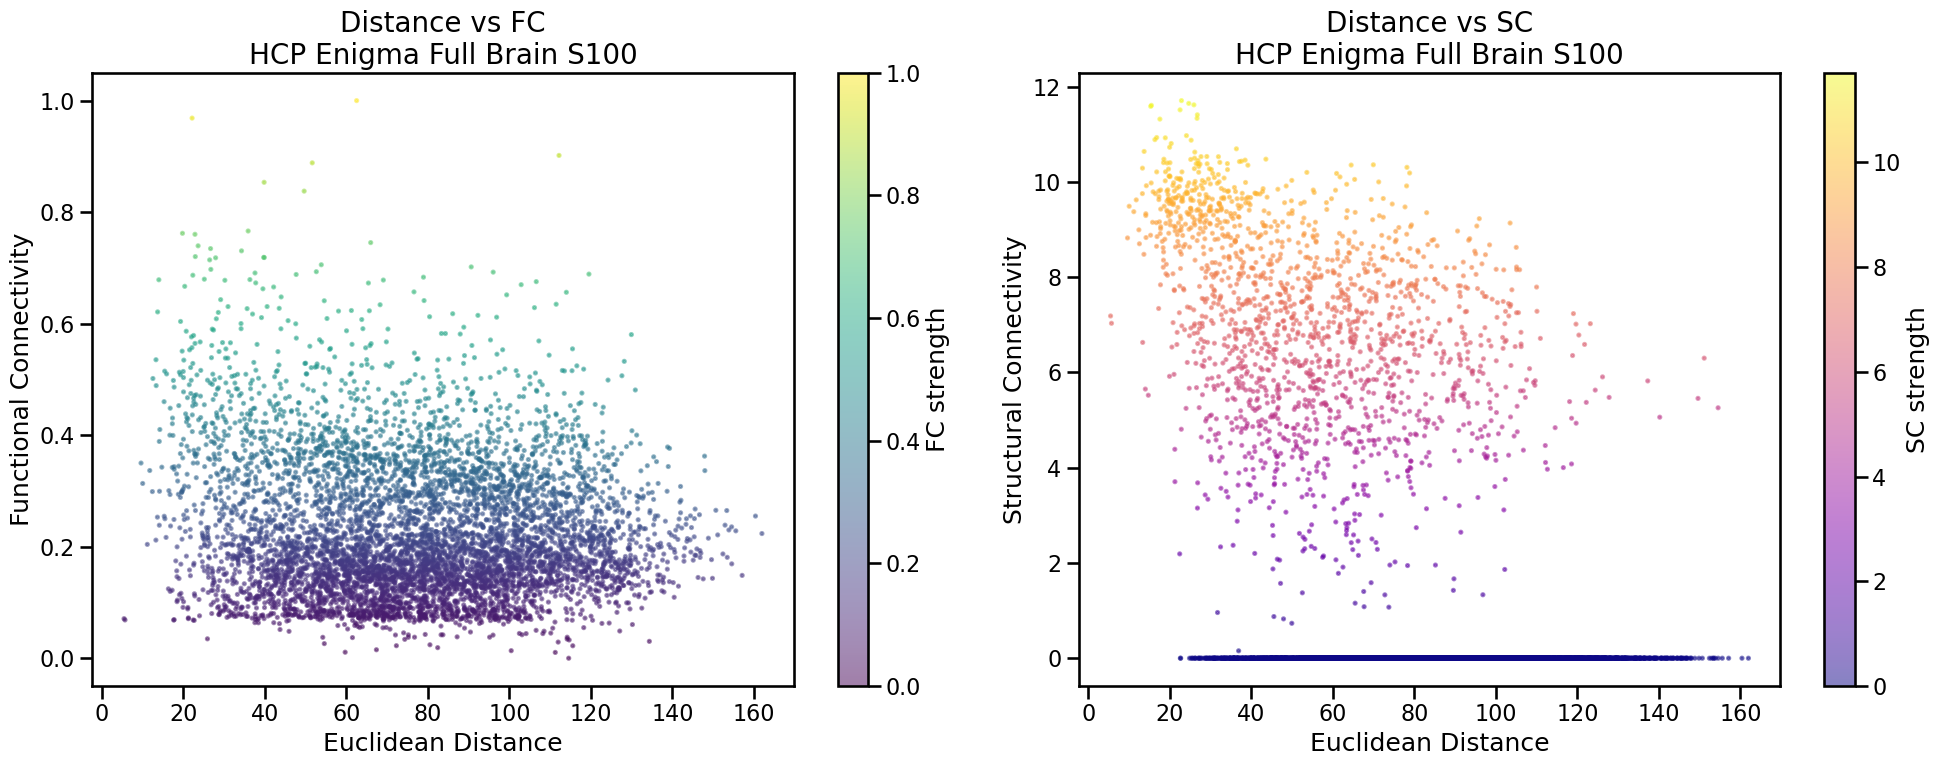

In [24]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot distance vs FC
scatter1 = ax1.scatter(features['distances'], features['fc_values'], 
                      c=features['fc_values'], cmap='viridis', alpha=0.5, s=5)
ax1.set_xlabel('Euclidean Distance', fontsize=18)
ax1.set_ylabel('Functional Connectivity', fontsize=18)
ax1.set_title('Distance vs FC\nHCP Enigma Full Brain S100', fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=16)
fig.colorbar(scatter1, ax=ax1, label='FC strength').ax.tick_params(labelsize=16)

# Plot distance vs SC 
scatter2 = ax2.scatter(features['distances'], features['sc_values'],
                      c=features['sc_values'], cmap='plasma', alpha=0.5, s=5)
ax2.set_xlabel('Euclidean Distance', fontsize=18)
ax2.set_ylabel('Structural Connectivity', fontsize=18)
ax2.set_title('Distance vs SC\nHCP Enigma Full Brain S100', fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=16)
fig.colorbar(scatter2, ax=ax2, label='SC strength').ax.tick_params(labelsize=16)

plt.tight_layout()
plt.show()

In [19]:
def analyze_feature_correlations(features, feature_names=None, labels=None):
    """
    Analyze correlations between features and check for NaN values.
    
    Parameters:
    features (dict): Dictionary containing feature arrays
    feature_names (list): List of feature names to analyze. If None, uses default list.
    labels (list): List of labels for plotting. If None, uses default list.
    """
    if feature_names is None:
        feature_names = ['distances', 'sc_values', 'fc_values', 'gene_coexpression', 
                        'gene_PCA_coexpression', 'spectral_similarity']
    if labels is None:
        labels = ['Distance', 'SC', 'FC', 'Gene Coexp', 'Gene PCA', 'Spectral']
        
    # Check for NaNs in each feature
    for name in feature_names:
        nan_mask = np.isnan(features[name])
        if np.any(nan_mask):
            print(f"NaNs detected in {name} at indices: {np.where(nan_mask)}")

    # Compute correlations between all pairs of features
    n = len(feature_names)
    correlations = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            correlations[i,j] = np.corrcoef(features[feature_names[i]], 
                                          features[feature_names[j]])[0,1]

    # Create heatmap
    plt.figure(figsize=(10,8))
    sns.heatmap(correlations,
                xticklabels=labels,
                yticklabels=labels, 
                annot=True,
                fmt='.3f',
                cmap='RdBu_r',
                center=0,
                vmin=-1,
                vmax=1,
                square=True)
    plt.title('Correlation heatmap')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Print individual correlations for reference
    print("\nDetailed correlations:")
    for i in range(n):
        for j in range(i+1,n):
            print(f"Correlation between {labels[i]} and {labels[j]}: {correlations[i,j]:.3f}")
            
    return correlations

Distances shape: (6441,)
SC values shape: (6441,)
FC values shape: (6441,)
Gene coexpression shape: (6441,)
Gene PCA coexpression shape: (6441,)
Spectral similarity shape: (6441,)
Gene PCA shape: (6441, 228)
Spectral embeddings shape: (6441, 26)
MNI coordinates shape: (6441, 6)


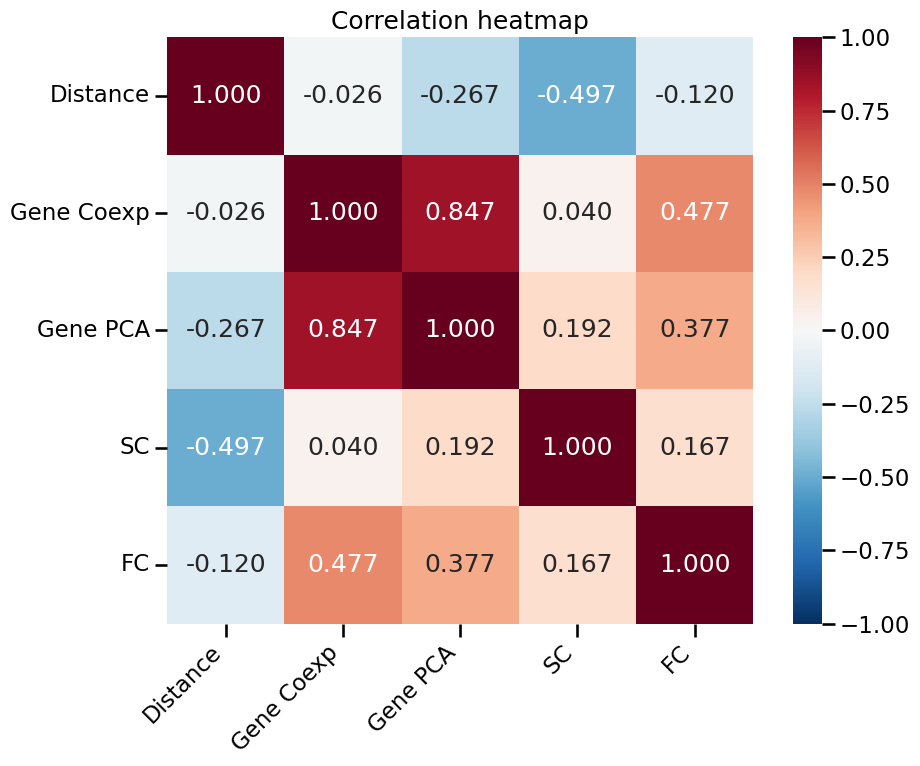


Detailed correlations:
Correlation between Distance and Gene Coexp: -0.026
Correlation between Distance and Gene PCA: -0.267
Correlation between Distance and SC: -0.497
Correlation between Distance and FC: -0.120
Correlation between Gene Coexp and Gene PCA: 0.847
Correlation between Gene Coexp and SC: 0.040
Correlation between Gene Coexp and FC: 0.477
Correlation between Gene PCA and SC: 0.192
Correlation between Gene PCA and FC: 0.377
Correlation between SC and FC: 0.167


array([[ 1.        , -0.02605848, -0.26744767, -0.49733444, -0.12010472],
       [-0.02605848,  1.        ,  0.84708931,  0.03974901,  0.47744384],
       [-0.26744767,  0.84708931,  1.        ,  0.1919739 ,  0.37651535],
       [-0.49733444,  0.03974901,  0.1919739 ,  1.        ,  0.16738703],
       [-0.12010472,  0.47744384,  0.37651535,  0.16738703,  1.        ]])

In [20]:
# Call the function with default parameters
features = construct_features_masked(
    X,
    Y_sc,
    Y_fc,
    mni_coords,
    mask_from=mask,
    mask_to=mask, 
    spectrals=13
)
print("Distances shape:", features['distances'].shape)
print("SC values shape:", features['sc_values'].shape)
print("FC values shape:", features['fc_values'].shape)
print("Gene coexpression shape:", features['gene_coexpression'].shape)
print("Gene PCA coexpression shape:", features['gene_PCA_coexpression'].shape)
print("Spectral similarity shape:", features['spectral_similarity'].shape)
print("Gene PCA shape:", features['edge_PCA_embeddings'].shape)
print("Spectral embeddings shape:", features['edge_spectral_embeddings'].shape)
print("MNI coordinates shape:", features['edge_mni_coords'].shape)

feature_names = ['distances', 'gene_coexpression', 'gene_PCA_coexpression', 'sc_values', 'fc_values',]
labels = ['Distance', 'Gene Coexp', 'Gene PCA', 'SC', 'FC',]

analyze_feature_correlations(features, feature_names, labels)

Interhemispheric connections only

In [48]:
X = AHBA_transcriptome
Y_sc = HCP_enigma_structural_count
Y_fc = HCP_enigma_functional_conn
mni_coords = HCP_coords
mask = np.array([True] * len(HCP_enigma_labels))

left_hemi_mask = np.zeros(len(HCP_enigma_labels), dtype=bool)
left_hemi_mask[HCP_enigma_lh_indices] = True
right_hemi_mask = np.zeros(len(HCP_enigma_labels), dtype=bool)
right_hemi_mask[HCP_enigma_rh_indices] = True

features = construct_features_masked(
    X,
    Y_sc,
    Y_fc,
    mni_coords,
    mask_from=left_hemi_mask,
    mask_to=right_hemi_mask, 
    spectrals=15
)

print("Distances shape:", features['distances'].shape)
print("SC values shape:", features['sc_values'].shape)
print("FC values shape:", features['fc_values'].shape)
print("Gene coexpression shape:", features['gene_coexpression'].shape)
print("Gene PCA coexpression shape:", features['gene_PCA_coexpression'].shape)
print("Spectral similarity shape:", features['spectral_similarity'].shape)
print("Gene PCA shape:", features['edge_PCA_embeddings'].shape)
print("Spectral embeddings shape:", features['edge_spectral_embeddings'].shape)
print("MNI coordinates shape:", features['edge_mni_coords'].shape)


Distances shape: (3249,)
SC values shape: (3249,)
FC values shape: (3249,)
Gene coexpression shape: (3249,)
Gene PCA coexpression shape: (3249,)
Spectral similarity shape: (3249,)
Gene PCA shape: (3249, 228)
Spectral embeddings shape: (3249, 30)
MNI coordinates shape: (3249, 6)


In [155]:
# Run GLM with 1D features
feature_names = ['distances', 'sc_values', 'gene_coexpression', 'gene_PCA_coexpression', 'spectral_similarity']
results, r_squared_values = fit_glm(features, feature_names, target_name='fc_values')

# Run GLM with all features
feature_names = ['distances', 'sc_values', 'gene_coexpression', 'gene_PCA_coexpression', 'spectral_similarity', 'edge_PCA_embeddings', 'edge_spectral_embeddings', 'edge_mni_coords']
results, r_squared_values = fit_glm(features, feature_names, target_name='fc_values')

Feature matrix shape: (28224, 6)

Full model summary:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     561.3
Date:                Tue, 10 Dec 2024   Prob (F-statistic):               0.00
Time:                        15:28:50   Log-Likelihood:                 7890.9
No. Observations:               28224   AIC:                        -1.577e+04
Df Residuals:                   28218   BIC:                        -1.572e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

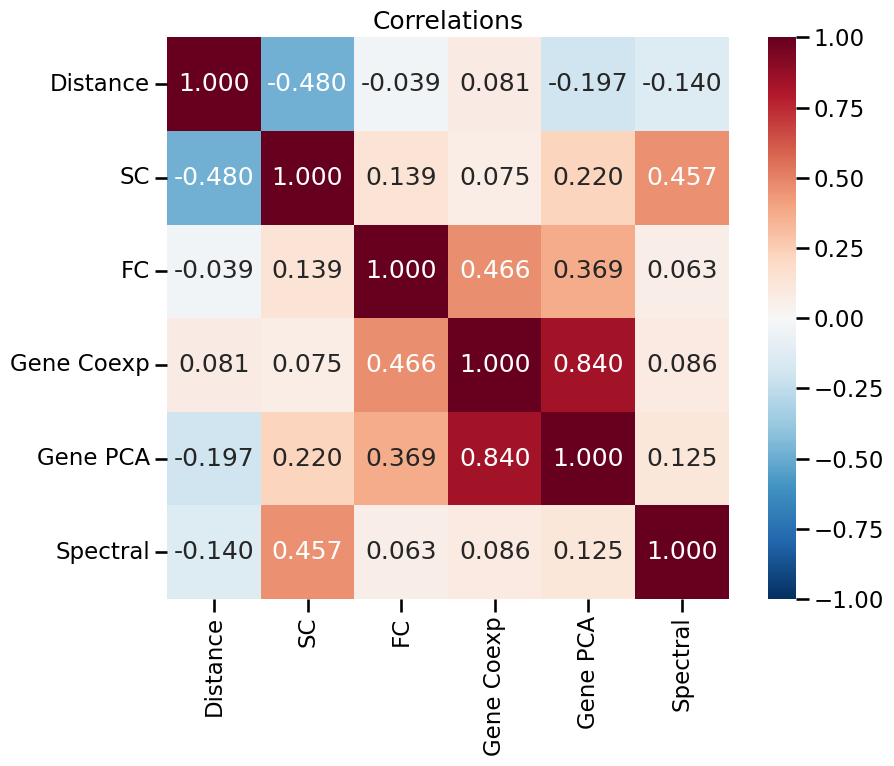


Detailed correlations:
Correlation between Distance and SC: -0.480
Correlation between Distance and FC: -0.039
Correlation between Distance and Gene Coexp: 0.081
Correlation between Distance and Gene PCA: -0.197
Correlation between Distance and Spectral: -0.140
Correlation between SC and FC: 0.139
Correlation between SC and Gene Coexp: 0.075
Correlation between SC and Gene PCA: 0.220
Correlation between SC and Spectral: 0.457
Correlation between FC and Gene Coexp: 0.466
Correlation between FC and Gene PCA: 0.369
Correlation between FC and Spectral: 0.063
Correlation between Gene Coexp and Gene PCA: 0.840
Correlation between Gene Coexp and Spectral: 0.086
Correlation between Gene PCA and Spectral: 0.125


array([[ 1.        , -0.4799383 , -0.03896833,  0.08094103, -0.19695279,
        -0.14039772],
       [-0.4799383 ,  1.        ,  0.13887476,  0.0752421 ,  0.22024884,
         0.45716952],
       [-0.03896833,  0.13887476,  1.        ,  0.46557533,  0.36868941,
         0.0633858 ],
       [ 0.08094103,  0.0752421 ,  0.46557533,  1.        ,  0.8401323 ,
         0.08601909],
       [-0.19695279,  0.22024884,  0.36868941,  0.8401323 ,  1.        ,
         0.12455197],
       [-0.14039772,  0.45716952,  0.0633858 ,  0.08601909,  0.12455197,
         1.        ]])

In [49]:
# Call the function with default parameters
analyze_feature_correlations(features)